In [1]:
import pandas as pd
from glob import glob
from collections import defaultdict
from IPython.display import display
import faiss, json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchbiggraph.model import ComplexDiagonalDynamicOperator, DotComparator, CosComparator
import numpy as np
from functools import lru_cache
from tqdm import tqdm
import h5py, torch

### Setup

In [2]:
# Faiss flat inner-product index
# index = faiss.read_index('wikidata_complEx.idx')

# Faiss IVFFlat inner-product index
# index = faiss.read_index('wikidata_complEx_IVFFlat_IP_5.idx')
index = faiss.read_index('wikidata_complEx_IVFFlat_IP_1024.idx')
index.nprobe = 256

# Faiss HNSW Flat index
# index = faiss.read_index('wikidata_complEx_HNSWFlat_4_IP.idx')
# index = faiss.read_index('wikidata_complEx_HNSWFlat_64_IP.idx')

In [3]:
# metadata
with open('metadata-w-fuzzy.json') as fd:
    metadata = json.load(fd)

# entity to index mapping
with open('qnodes_id.json') as fd:
    complEx_entity_index = json.load(fd)
entity_count = len(complEx_entity_index)
complEx_index_entity = {v: k for k, v in complEx_entity_index.items()}

# relational to index mapping
rel_type_names = pd.read_csv('relation_types_tf.tsv', sep='\t', header=None)[0][:1285].to_list()
rel_index = {r: i for i, r in enumerate(rel_type_names)}
index_rel = {v: k for k, v in rel_index.items()}

In [4]:
# specify dimension
dim = 100

# operators
operator_lhs = ComplexDiagonalDynamicOperator(dim, 1285)
operator_rhs = ComplexDiagonalDynamicOperator(dim, 1285)
comparator = DotComparator()
cos_comparator = CosComparator()

# Load the operator's state dict
with h5py.File("model.v600.h5", "r") as hf:
    operator_state_dict_lhs = {
        "real": torch.from_numpy(hf["model/relations/0/operator/lhs/real"][...]),
        "imag": torch.from_numpy(hf["model/relations/0/operator/lhs/imag"][...]),
    }
    operator_state_dict_rhs = {
        "real": torch.from_numpy(hf["model/relations/0/operator/rhs/real"][...]),
        "imag": torch.from_numpy(hf["model/relations/0/operator/rhs/imag"][...]),
    }

operator_lhs.load_state_dict(operator_state_dict_lhs)
operator_rhs.load_state_dict(operator_state_dict_rhs)

# Load the embeddings
with h5py.File("embeddings_all_0.v600.h5", "r") as hf:
    embedding = torch.from_numpy(hf["embeddings"][...])

### Utility functions

In [5]:
@lru_cache(maxsize = 50000)
def get_embed(head, relation=None):
    ''' This function generate the embeddings for the tail entities:
            Head entities: Obtained from the model
            Head + relation: Obtained using torch
    '''
    if relation is None:
        return embedding[complEx_entity_index[head], :].detach().numpy()
    return  operator_lhs(
                embedding[complEx_entity_index[head], :].view(1, dim),
                torch.tensor([rel_index[relation]])
            ).detach().numpy()[0]

In [6]:
@lru_cache(maxsize = 10000)
def get_embed_rev(tail, relation=None):
    ''' This function generate the embeddings for the head entities:
            Tail entities: Obtained from the model
            Tail - relation: Obtained using torch
    '''
    if relation is None:
        return embedding[complEx_entity_index[tail], :].detach().numpy()
    return  operator_rhs(
                embedding[complEx_entity_index[tail], :].view(1, dim),
                torch.tensor([rel_index[relation]])
            ).detach().numpy()[0]

In [7]:
@lru_cache(maxsize=10000)
def neighbors_torch(qnode, relation):
    ''' This function returns the nearest neighbors,
        given the head and the relation (Using the torch command)
    '''
    # Load the offsets of the entities and the index of the relation type
    src_entity_offset = complEx_entity_index[qnode]
    rel_type_index = rel_type_names.index(relation)

    src_embedding = embedding[src_entity_offset, :]
    dest_embeddings = embedding

    # Calculate the scores
    scores, _, _ = comparator(
        comparator.prepare(src_embedding.view(1, 1, dim)).expand(1, entity_count, dim),
        comparator.prepare(
            operator_rhs(
                dest_embeddings,
                torch.tensor([rel_type_index]).expand(entity_count),
            ).view(1, entity_count, dim),
        ),
        torch.empty(1, 0, dim),  # Left-hand side negatives, not needed
        torch.empty(1, 0, dim),  # Right-hand side negatives, not needed
    )
    
    return scores.flatten()

In [8]:
@lru_cache(maxsize=10000)
def neighbors_faiss(head, relation, tail=None, k=10):
    ''' This function returns the nearest neighbors
        given the head and the relation (Using the Faiss index)
    '''
    if not tail:
        return index.search(get_embed(head, relation).reshape(1,-1), k)
    else:
        return index.search(get_embed_rev(tail, relation).reshape(1,-1), k)

In [9]:
def neighbors(head, relation, tail=None, k=10):
    ''' This function returns the nearest neighbors
        given the head and the relation (Using the Faiss index)
    '''
    if not tail:
        return index.search(get_embed(head, relation).reshape(1,-1), k)
    else:
        return index.search(get_embed_rev(tail, relation).reshape(1,-1), k)

In [10]:
def get_neighbors(head, relation, tail=None, k=10):
    scores, ranking = neighbors_faiss(head, relation, tail)
    # scores, ranking = neighbors(head, relation, tail)
    top_entities = [complEx_index_entity[index] for index in ranking[0] if index>0]
    top_scores = scores[0][:len(top_entities)]
    return top_scores, top_entities

In [11]:
def has_candidate(head, relation, tail=None, cutoff=10, k=5, verbose=False):
    ''' Given a qnode and a relation, 
        check if the candidate has a valid tail entity that is above the cut off points
    '''

    top_scores, top_entities = get_neighbors(head, relation, tail, k)
    # print(head, relation, tail)
    # print(top_entities)
    # print(top_scores)
        
    for e, s in zip(top_entities, top_scores):
        # print(e)
        if e == head or e == tail:
            continue
        if s >= cutoff:
            if verbose:
                print(e, s)
            return e
        
    return None

In [12]:
def get_centroid(qnodes):
    ''' Calculate the centroid of a given list of qnodes '''
    embeddings = [get_embed(qnode) for qnode in qnodes]
    return np.mean(embeddings, axis=0)

### Graph extract

In [13]:
# Macros
SINGLETON_CORRECT = 'singleton (correct)'
SINGLETON_INCORRECT = 'singleton (incorrect)'
NON_SINGLETON_CORRECT = 'nonsingleton (correct)'
NON_SINGLETON_INCORRECT = 'nonsingleton (incorrect)'
FUZZY_CORRECT = 'correct'
FUZZY_INCORRECT = 'incorrect'
AMBIGUOUS = 'ambiguous'

In [14]:
def assign_group(qnode, datasetid, target='exact'):
    ''' Assign the groups of entities based on evaluation '''
    if target == 'exact':
        if qnode in metadata[datasetid]['exact']['singleton-correct']:
            return SINGLETON_CORRECT
        if qnode in metadata[datasetid]['exact']['singleton-incorrect']:
            return SINGLETON_INCORRECT
        if qnode in metadata[datasetid]['exact']['non-singleton-correct']: 
            return NON_SINGLETON_CORRECT
        return NON_SINGLETON_INCORRECT
    else:
        if qnode in metadata[datasetid]['fuzzy']['correct']:
            return FUZZY_CORRECT
        if qnode in metadata[datasetid]['fuzzy']['incorrect']:
            return FUZZY_INCORRECT

In [15]:
def build_candidates(datasetid, target='exact', singleton=False, correct=False):
    ''' Build the candidate array from the dataset '''
    if target == 'exact':
        if not singleton and not correct:
            array = metadata[datasetid]['exact']['singleton-correct'] + \
                    metadata[datasetid]['exact']['singleton-incorrect'] + \
                    metadata[datasetid]['exact']['non-singleton-correct'] + \
                    metadata[datasetid]['exact']['non-singleton-incorrect']
        elif singleton and not correct:
            array = metadata[datasetid]['exact']['singleton-correct'] + \
                    metadata[datasetid]['exact']['singleton-incorrect']
        else:
            array = metadata[datasetid]['exact']['singleton-correct'] 
    else:
        array = metadata[datasetid]['fuzzy']['correct'] + \
                metadata[datasetid]['fuzzy']['incorrect']
    return array

In [16]:
def drop_candidates(candidates):
    ''' Drop the entities that do not have graph embeddings '''
    # Drop qnodes that are not in the index
    olen = len(candidates)
    candidates = [qnode for qnode in candidates if qnode in complEx_entity_index]
    print(f'{olen-len(candidates)} entities dropped.')
    return candidates

In [17]:
def graph_entities(candidates, labels, embeddings,
                   target='exact', perplexity=5, metric='euclidean'):
    ''' Graph the candidates that have an embedding '''
    
    # Prepare the TSNE graph for the candidates
    reduced_embeddings = TSNE(perplexity=perplexity, metric=metric, n_iter=5000).fit_transform(embeddings)

    df = pd.DataFrame(dict(x=[x[0] for x in reduced_embeddings], 
                           y=[x[1] for x in reduced_embeddings], 
                           label=labels))
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(12,9))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax.title.set_text(f'TSNE of Graph Embeddings, perplexity={perplexity}')
    for name, group in groups:
        if name == SINGLETON_CORRECT or name == FUZZY_CORRECT:
            ax.plot(group.x, group.y, marker='o', linestyle='', color='g', ms=8, label=name)
        elif name == NON_SINGLETON_CORRECT:
            ax.plot(group.x, group.y, marker='o', linestyle='', color='b', ms=8, label=name)
        elif name == SINGLETON_INCORRECT:
            ax.plot(group.x, group.y, marker='X', linestyle='', color='r', ms=8, label=name)
        elif name == AMBIGUOUS:
            ax.plot(group.x, group.y, marker='P', color='m', linestyle='', ms=6, label=name)
        elif 'reverse' in name:
            if SINGLETON_CORRECT in name:
                ax.plot(group.x, group.y, marker='*', linestyle='', color='g', ms=8, label=name)
            elif NON_SINGLETON_CORRECT in name:
                ax.plot(group.x, group.y, marker='*', linestyle='', color='b', ms=8, label=name)
            elif SINGLETON_INCORRECT in name:
                ax.plot(group.x, group.y, marker='_', linestyle='', color='r', ms=8, label=name)                
            else:
                ax.plot(group.x, group.y, marker='_', linestyle='', ms=6, label=name)
        else:
            ax.plot(group.x, group.y, marker='x', color='y', linestyle='', ms=6, label=name)
    ax.legend(bbox_to_anchor=(1,0.25), loc='upper left')
        
    plt.show()

In [18]:
def get_top_tails(datasetid, candidates, relation, target='exact'):
    ''' Given a list of candidates, check their top candidate '''
    
    projections = defaultdict(set)
    counts = defaultdict(set)
    for cand in candidates:
        
        for ent in get_neighbors(cand, relation)[1]:
            
            # skip itself
            if ent == cand:
                continue
            
            # Keep the grouping info
            group_id = assign_group(cand, datasetid, target)
            projections[group_id].add(ent)
            if group_id in [SINGLETON_CORRECT, NON_SINGLETON_CORRECT, FUZZY_CORRECT]:
                counts[ent].add('correct')
            else:
                counts[ent].add('incorrect')
            
            # Add the highest ranking only
            break
    
    # Convert group info to counts
    for ent in counts:
        counts[ent] = len(counts[ent])
    
    # Count ambiguous entities (mapped by both incorrect and correct ones)
    ambiguities = set()
    for ent in counts:
        if counts[ent] > 1:
            ambiguities.add(ent)
            
    for k in projections:
        # remove ambiguities
        for ent in ambiguities:
            projections[k].discard(ent)
    
    # append ambigous entities
    projections['ambiguous'] = ambiguities
    
    # Convert to list
    output_qnodes = []
    output_labels = []
    for label in projections:
        for qnode in projections[label]:
            output_qnodes.append(qnode)
            output_labels.append(label)
            
    return output_qnodes, output_labels

In [19]:
def graph_embeddings(datasetid, relation=None, target='exact', perplexity=5, 
                metric='euclidean', skip=False, truncate=None):
    
    # Get candidates from dataset, also drop those who do not have embeddings
    candidates = build_candidates(datasetid, target=target)
    candidates = drop_candidates(candidates)    
    labels = [assign_group(qnode, datasetid, target) for qnode in candidates]

    # Graph 1: The embeddings of the original graph
    if not skip:
        embeddings = [get_embed(qnode) for qnode in candidates]
        graph_entities(candidates, labels, embeddings, perplexity=perplexity)
    
    if relation:

        if truncate:
            # Summary statistics
            prev_len = len(candidates)
            if target == 'exact':
                sin_c = len([x for x in labels if x == SINGLETON_CORRECT])
                sin_ic = len([x for x in labels if x == SINGLETON_INCORRECT])
                nonsin_c = len([x for x in labels if x == NON_SINGLETON_CORRECT])
                nonsin_ic = len([x for x in labels if x == NON_SINGLETON_INCORRECT])
            else:
                c = len([x for x in labels if x == FUZZY_CORRECT])
                ic = len([x for x in labels if x == FUZZY_INCORRECT])
            
            candidates = [qnode for qnode in candidates if has_candidate(qnode, relation, cutoff=truncate)]
            labels = [assign_group(qnode, datasetid, target) for qnode in candidates]
            # Summary
            print(f'{len(candidates)-prev_len} cases truncated')
            if target == 'exact':
                sin_c_t = len([x for x in labels if x == SINGLETON_CORRECT])
                print(f'singleton (correct): {sin_c - sin_c_t} output of {sin_c}, percent: {(sin_c - sin_c_t) / sin_c}')
                sin_ic_t = len([x for x in labels if x == SINGLETON_INCORRECT])
                print(f'singleton (incorrect): {sin_ic - sin_ic_t} output of {sin_ic}, percent: {(sin_ic - sin_ic_t) / sin_ic}')
                nonsin_c_t = len([x for x in labels if x == NON_SINGLETON_CORRECT])
                print(f'nonsingleton (correct): {nonsin_c - nonsin_c_t} output of {nonsin_c}, percent: {(nonsin_c - nonsin_c_t) / nonsin_c}')
                nonsin_ic_t = len([x for x in labels if x == NON_SINGLETON_INCORRECT])
                print(f'nonsingleton (correct): {nonsin_ic - nonsin_ic_t} output of {nonsin_ic}, percent: {(nonsin_ic - nonsin_ic_t) / nonsin_ic}')
            else:
                c = len([x for x in labels if x == FUZZY_CORRECT])
                ic = len([x for x in labels if x == FUZZY_INCORRECT])
            
            projected_embeddings = [get_embed_rev(qnode, relation) for qnode in candidates]
            # Graph2b: Projected Embeddings with truncation
            graph_entities(candidates, labels, projected_embeddings, perplexity=perplexity)    
        else:
            # Graph2a: Projected Embeddings
            projected_embeddings = [get_embed_rev(qnode, relation) for qnode in candidates]
            graph_entities(candidates, labels, projected_embeddings, perplexity=perplexity)            
             
        # Graph 3: The distinct projections of the candidates
        mapped_nodes, mapped_labels = get_top_tails(datasetid, candidates, relation, target=target)
        mapped_embeddings = [get_embed(qnode) for qnode in mapped_nodes]
        graph_entities(mapped_nodes, mapped_labels, mapped_embeddings, perplexity=perplexity)
        
        distance_singleton_all = None
        distance_singleton_correct = None
        # Calculate the centroid of singletons, non-singletons
        if target == 'exact':
            centroid_singleton = get_centroid(build_candidates(datasetid, target=target, singleton=True))
            centroid_singleton_correct = get_centroid(build_candidates(datasetid, target=target, singleton=True, correct=True))
        
            distance_singleton_all = defaultdict(list)
            distance_singleton_correct = defaultdict(list)
            for qnode, label in zip(mapped_nodes, mapped_labels):
                neighbors = get_neighbors(None, relation, qnode)[1]
                distance_singleton_all[label].append(np.linalg.norm(get_centroid(neighbors) - centroid_singleton))
                distance_singleton_correct[label].append(np.linalg.norm(get_centroid(neighbors) - centroid_singleton_correct))
            
            # Average the distance to centroids
            for k in distance_singleton_all:
                distance_singleton_all[k] = np.mean(distance_singleton_all[k])
                distance_singleton_correct[k] = np.mean(distance_singleton_correct[k])
                    
        # Graph 4: Calculate the reversedly-projected embeddings, along with the embeddings in the original space
        rev_embeddings = [get_embed_rev(qnode, relation) for qnode in mapped_nodes]
        for i in range(len(mapped_labels)):
            mapped_labels[i] += ' - reverse'
        embeddings = [get_embed(qnode) for qnode in candidates]
        graph_entities(candidates + mapped_nodes, labels + mapped_labels, embeddings + rev_embeddings, 
                       perplexity=perplexity)
                
        return distance_singleton_all, distance_singleton_correct

In [20]:
metadata.keys()

dict_keys(['14067031', '14380604', '28086084', '29414811', '39759273', '45073662', '50270082', '52299421', '84575189'])

### Pope dataset

In [21]:
key = '28086084'
metric_ = 'cosine'
property_ = 'P106'
group = 'exact'
skip = False
truncate = 10

30 entities dropped.


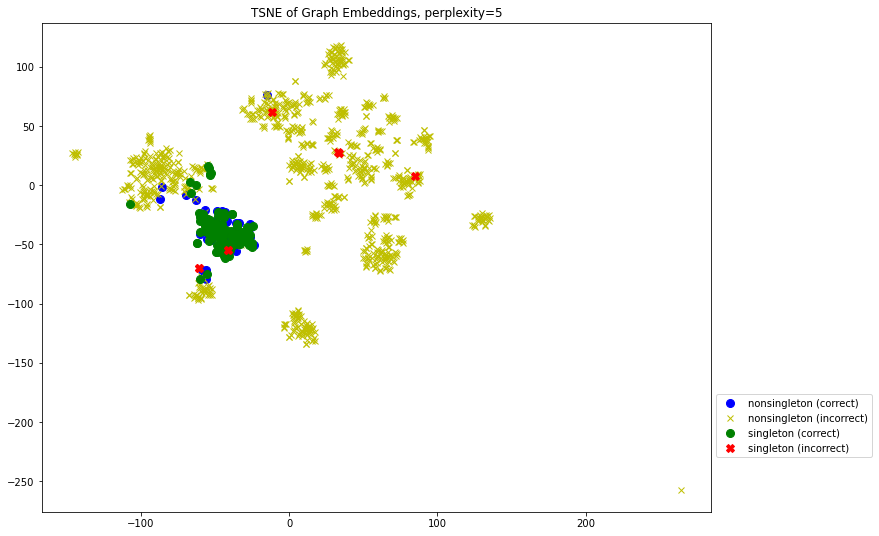

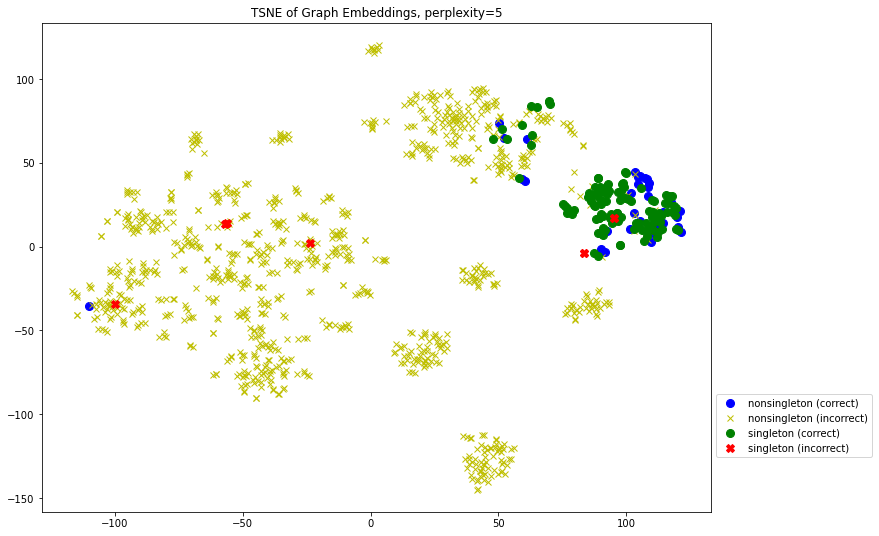

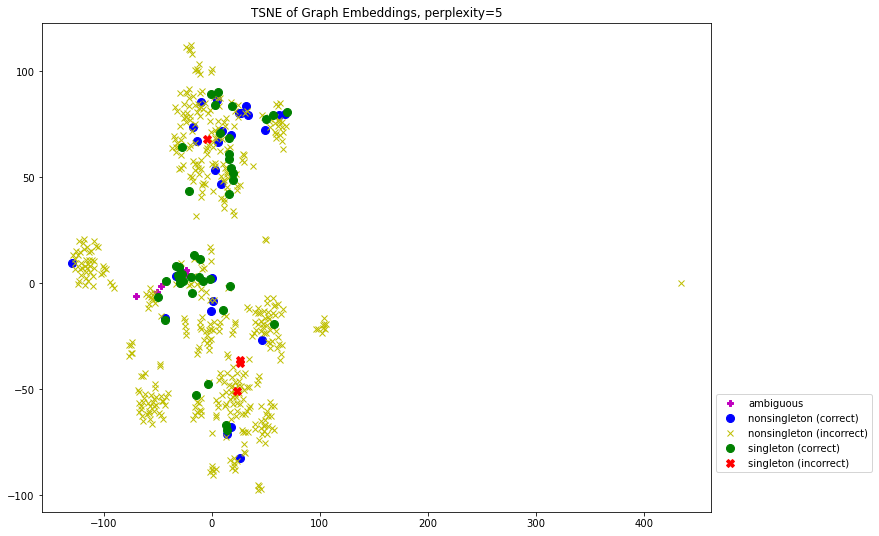

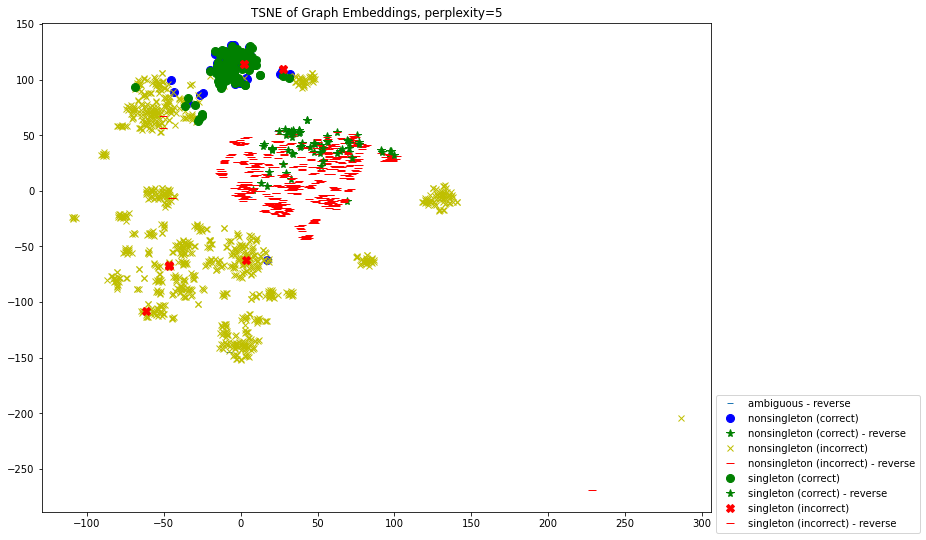

(defaultdict(list,
             {'singleton (correct)': 2.5404174,
              'singleton (incorrect)': 3.6451497,
              'nonsingleton (correct)': 2.8226166,
              'nonsingleton (incorrect)': 3.3598619,
              'ambiguous': 2.7809756}),
 defaultdict(list,
             {'singleton (correct)': 2.5787182,
              'singleton (incorrect)': 3.7171926,
              'nonsingleton (correct)': 2.8611448,
              'nonsingleton (incorrect)': 3.4209816,
              'ambiguous': 2.8112047}))

In [22]:
graph_embeddings(key, property_, group, perplexity=5, metric=metric_, \
                 skip=skip, truncate=None)

30 entities dropped.


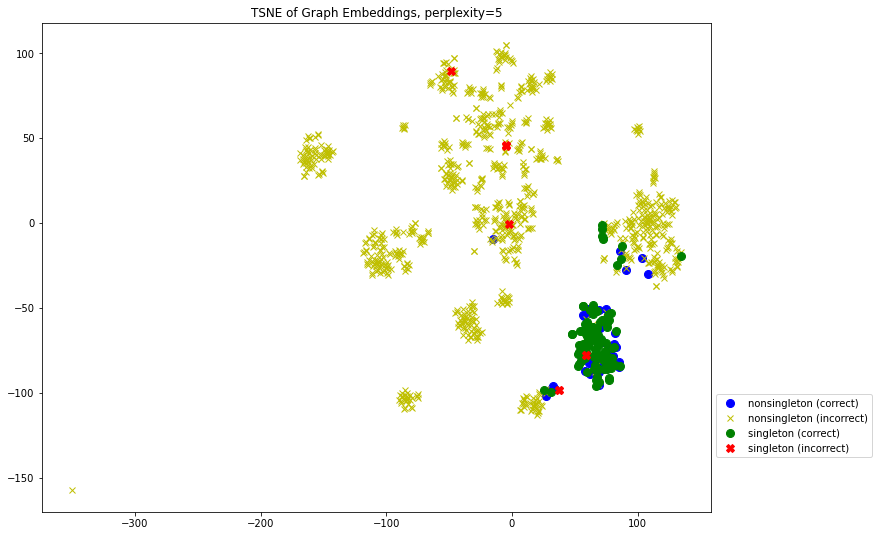

-965 cases truncated
singleton (correct): 79 output of 116, percent: 0.6810344827586207
singleton (incorrect): 8 output of 8, percent: 1.0
nonsingleton (correct): 9 output of 34, percent: 0.2647058823529412
nonsingleton (correct): 869 output of 991, percent: 0.8768920282542886


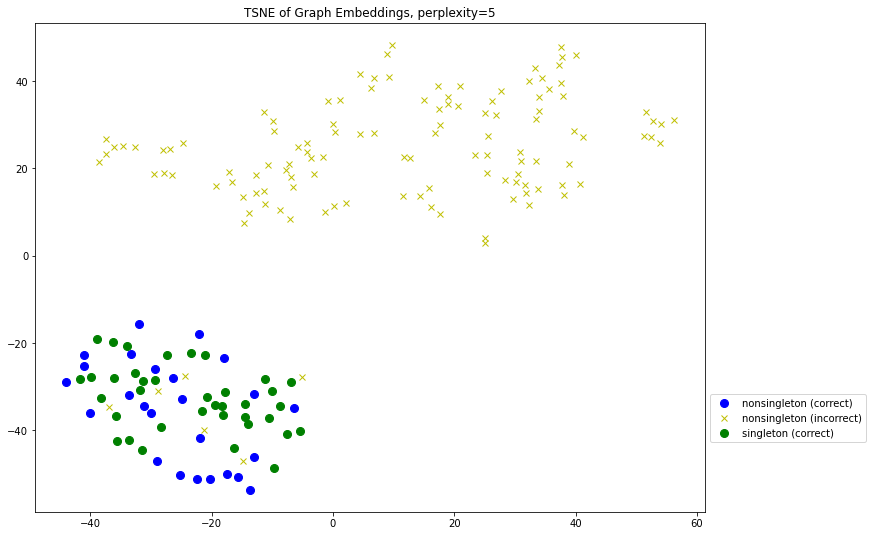

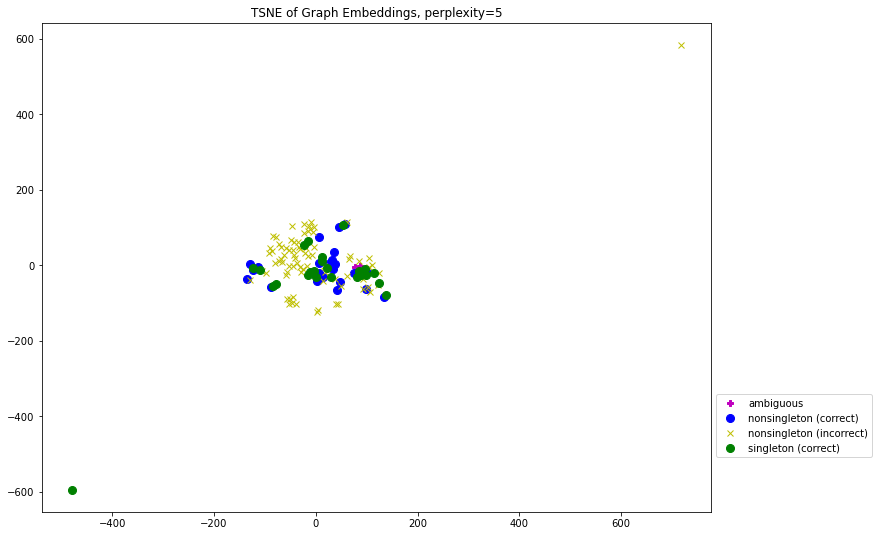

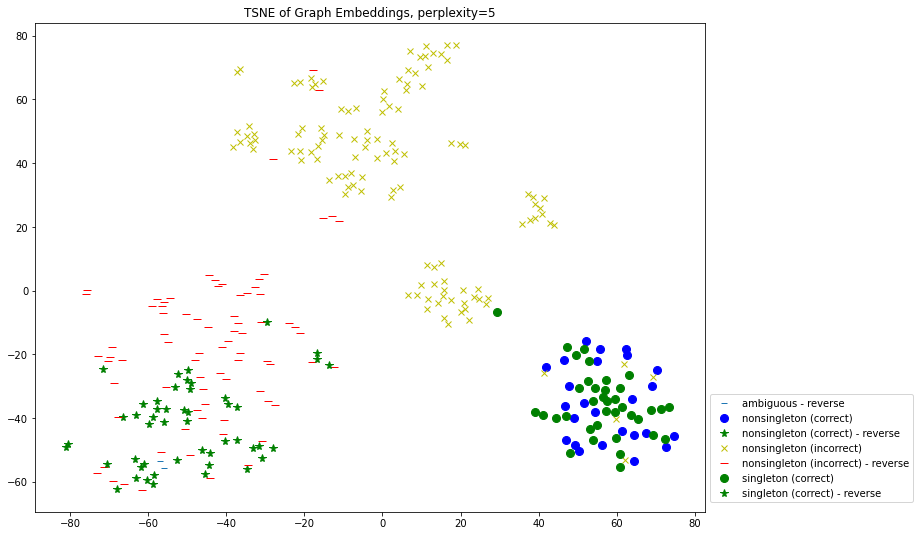

(defaultdict(list,
             {'singleton (correct)': 2.4760778,
              'nonsingleton (correct)': 2.7738209,
              'nonsingleton (incorrect)': 3.3917346,
              'ambiguous': 1.5289707}),
 defaultdict(list,
             {'singleton (correct)': 2.5084627,
              'nonsingleton (correct)': 2.811237,
              'nonsingleton (incorrect)': 3.4474428,
              'ambiguous': 1.5339768}))

In [23]:
graph_embeddings(key, property_, group, perplexity=5, metric=metric_, \
                 skip=skip, truncate=truncate)